In [61]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
from src.concept_utils import conceptExample, gate_score
import numpy as np

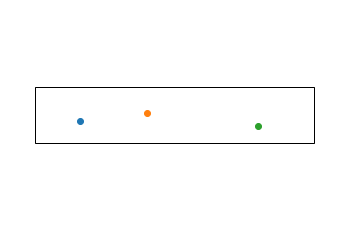

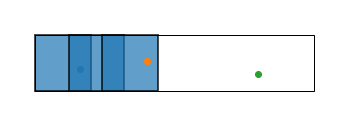

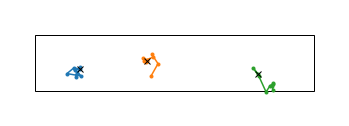

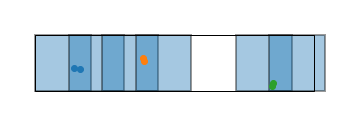

In [98]:
ce = conceptExample(var=0.1)

ce.plot_starting()
ce.plot_cams()
ce.plot_paths()
ce.plot_detections()


In [99]:
ce.df

,time,individual,x,y
0,0,0,0.800000,0.385090
1,1,0,0.693903,0.411808
2,2,1,1.948726,0.534014
3,3,1,1.941339,0.592971
4,6,2,4.270853,0.137536
5,7,2,4.251683,0.086452


In [100]:
def step_tracks(t, tracks, ce):
    det = ce.df[ce.df["time" ]==t]
    return ce.update_tracks(det, tracks)

In [101]:
def step_tracks_scores(t, tracks, ce, scores):
    det = ce.df[ce.df["time" ]==t]
#     gate_score(t, ce.df, ce.var, ce.thresh, np.multiply(*ce.cam_area), 3/5)
    return ce.update_score_tracks(det, tracks, scores)

In [102]:
ce.df

,time,individual,x,y
0,0,0,0.800000,0.385090
1,1,0,0.693903,0.411808
2,2,1,1.948726,0.534014
3,3,1,1.941339,0.592971
4,6,2,4.270853,0.137536
5,7,2,4.251683,0.086452


Make tracks and score them

In [103]:
tracks = ce.make_first_track()
scores = [0,0]

In [104]:
tracks1, scores1 = step_tracks_scores(1, tracks, ce, scores)
tracks2, scores2 = step_tracks_scores(2, tracks1, ce, scores1)
tracks3, scores3 = step_tracks_scores(3, tracks2, ce, scores2)
tracks4, scores4 = step_tracks_scores(4, tracks3, ce, scores3)
tracks5, scores5 = step_tracks_scores(5, tracks4, ce, scores4)
tracks6, scores6 = step_tracks_scores(6, tracks5, ce, scores5)

insnan last
insnan last
insnan last
Gated detection 4 from 0
Gated detection 4 from 3
Gated detection 4 from 2
Gated detection 4 from 3
Gated detection 4 from 1
Gated detection 4 from 3
Gated detection 4 from 2
Gated detection 4 from 3
insnan last
Gated detection 4 from 3
Gated detection 4 from 2
Gated detection 4 from 3
Gated detection 4 from 1
Gated detection 4 from 3
Gated detection 4 from 2
Gated detection 4 from 3


In [105]:
np.log(0.4)#1-ce.density * np.multiply(*ce.cam_area)

-0.916290731874155

In [106]:
for i, t in enumerate(tracks1):
    print(t, scores1[i])

[0, nan] -0.10536051565782628
[0, 1] 0.44740890017096163
[nan, nan] -0.10536051565782628
[nan, 1] -0.10536051565782628


In [107]:
for i, t in enumerate(tracks2):
    print(t, scores2[i])

[0, nan, nan] -0.21072103131565256
[0, nan, 2] -0.592812193751166
[0, 1, nan] 0.34204838451313535
[0, 1, 2] 0.7127733141367227
[nan, nan, nan] -0.21072103131565256
[nan, nan, 2] -0.21072103131565256
[nan, 1, nan] -0.21072103131565256
[nan, 1, 2] 0.16000389830793488


**Make graph**

In [108]:
tracks6

[[0, nan, nan, nan, nan, nan, nan],
 [0, nan, nan, 3, nan, nan, nan],
 [0, nan, 2, nan, nan, nan, nan],
 [0, nan, 2, 3, nan, nan, nan],
 [0, 1, nan, nan, nan, nan, nan],
 [0, 1, nan, 3, nan, nan, nan],
 [0, 1, 2, nan, nan, nan, nan],
 [0, 1, 2, 3, nan, nan, nan],
 [nan, nan, nan, nan, nan, nan, nan],
 [nan, nan, nan, nan, nan, nan, 4],
 [nan, nan, nan, 3, nan, nan, nan],
 [nan, nan, 2, nan, nan, nan, nan],
 [nan, nan, 2, 3, nan, nan, nan],
 [nan, 1, nan, nan, nan, nan, nan],
 [nan, 1, nan, 3, nan, nan, nan],
 [nan, 1, 2, nan, nan, nan, nan],
 [nan, 1, 2, 3, nan, nan, nan]]

In [109]:
gtrack = np.array(tracks6)

In [110]:
import igraph

Graph building
1. Each track is a node
2. tracks which share a detection are incompatible so have an edge between

Make a graph with n vertices (where n is number of tracks)

In [111]:
g = igraph.Graph()
nverts = len(gtrack)
g.add_vertices(nverts)

Find the incompatible tracks

In [112]:
edges = []

for i, tr in enumerate(gtrack):
    diff = tr - gtrack
    for d in np.where(diff==0)[0]:
        if d != i:
            edges.append((i, d))

add edges to the graph

In [113]:
g.add_edges(edges)

In [114]:
hyps = g.maximal_independent_vertex_sets()

In [115]:
hyps

[(0, 8, 9, 10, 11, 13),
 (0, 8, 9, 10, 15),
 (0, 8, 9, 16),
 (0, 8, 9, 11, 14),
 (0, 8, 9, 12, 13),
 (1, 8, 9, 11, 13),
 (1, 8, 9, 15),
 (2, 8, 9, 10, 13),
 (2, 8, 9, 14),
 (3, 8, 9, 13),
 (4, 8, 9, 10, 11),
 (4, 8, 9, 12),
 (5, 8, 9, 11),
 (6, 8, 9, 10),
 (7, 8, 9)]

Score the generated hypotheses

In [116]:
def score_hypotheses(hyps, scores):
    hscores = []
    for hyp in hyps:
        hscores.append(np.sum([scores[h] for h in hyp]))
    return hscores

In [117]:
hscores = score_hypotheses(hyps,scores6 )

In [118]:
for i, h in enumerate(hscores):
    print(hyps[i], h)

(0, 8, 9, 10, 11, 13) -3.7929785636817472
(0, 8, 9, 10, 15) -2.7900905401112013
(0, 8, 9, 16) -1.5972537069956028
(0, 8, 9, 11, 14) -3.565755575742573
(0, 8, 9, 12, 13) -2.600141730566148
(1, 8, 9, 11, 13) -4.007070194950053
(1, 8, 9, 15) -3.004182171379507
(2, 8, 9, 10, 13) -3.542906632170303
(2, 8, 9, 14) -3.315683644231129
(3, 8, 9, 13) -2.3500697990547037
(4, 8, 9, 10, 11) -2.608046053906001
(4, 8, 9, 12) -1.415209220790402
(5, 8, 9, 11) -2.380823065966827
(6, 8, 9, 10) -1.6051580303354558
(7, 8, 9) -0.41232119721985727


In [119]:
nscores = []
for i, h in enumerate(hscores):
    nscores.append(h/len(hyps[i]))

In [120]:
np.argsort(nscores)

array([ 8,  5,  6,  3,  7,  0, 12,  9,  1, 10,  4, 13,  2, 11, 14])

In [121]:
np.argsort(hscores)

array([ 5,  0,  3,  7,  8,  6,  1, 10,  4, 12,  9, 13,  2, 11, 14])

In [125]:
[gtrack[h] for h in hyps[11]]

[array([ 0.,  1., nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan, nan,  4.]),
 array([nan, nan,  2.,  3., nan, nan, nan])]

In [123]:
for i in [83, 101]:
    print( [gtrack[h] for h in hyps[i]])
    print(hscores[i])

IndexError: list index out of range

In [53]:
np.linalg.det(np.array([[3, 0], [0, 3]]))

9.000000000000002

In [97]:
np.log(0.01)

-4.605170185988091